In [39]:
import numpy as np
import pandas as pd
from datetime import datetime

df = pd.read_csv(r'C:\Users\paren\Documents\Projects\Kaggle - Pred Sales\sales_train.csv')

df['date'] = pd.to_datetime(df['date'], format = '%d.%m.%Y')
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
del df['date']

#df.loc[(df['shop_id'] == 59) & (df['item_id'] == 22164) & (df['year'] == 2015) & (df['month'] == 7)]
df = df.groupby(['shop_id', 'item_id', 'month', 'year', 'date_block_num']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'})
df = df.reset_index()

item_to_cat_df = pd.read_csv(r'C:\Users\paren\Documents\Projects\Kaggle - Pred Sales\items.csv')
del item_to_cat_df['item_name']
del item_to_cat_df['item_id']
item_to_cat_df.columns = ['item_id']

item_to_cat = item_to_cat_df.to_dict()
item_to_cat
df['category'] = df['item_id'].map(item_to_cat['item_id'])





test_df = pd.read_csv(r'C:\Users\paren\Documents\Projects\Kaggle - Pred Sales\test.csv')
#del test_df['ID']
test_df['year'] = 2015
test_df['month'] = 10
test_df['date_block_num'] = 34
test_df['category'] = test_df['item_id'].map(item_to_cat['item_id'])

# Now get price
df = df.sort_values(by = 'date_block_num')
for_price = df.drop_duplicates(subset = 'item_id', keep = 'last')
for_price = for_price[['item_id', 'item_price']]

test_df = test_df.merge(for_price, how ='left', on = ['item_id'])



notna_df = test_df.loc[test_df['item_price'].notna()]
na_df = test_df.loc[test_df['item_price'].isna()]
del na_df['item_price']
for_price = df.drop_duplicates(subset = 'item_id', keep = 'last')
for_price = for_price[['category', 'item_price']]
for_price = for_price.groupby(['category']).agg({'item_price' : 'mean'})
for_price = for_price.reset_index()


na_df = na_df.merge(for_price, how ='left', on = ['category'])

# Here is the final test:
#test_df_final = test_df.merge(na_df, how ='left', on = ['item_id', 'shop_id', 'year', 'month', 'date_block_num', 'category'])
test_df_final = pd.concat([notna_df, na_df],ignore_index=True)
test_df_final = test_df_final.sort_values(by = 'item_id')


# get average shop sales per month
df['store_strength'] = df['item_price'] * df['item_cnt_day']
df['date_block_num^2'] = df['date_block_num'] * df['date_block_num']
df['store_strength*date_block'] = df['store_strength'] * df['date_block_num']
temp = df

temp = temp.groupby(['shop_id']).agg({'store_strength' : 'mean', 'date_block_num' : 'mean', 'date_block_num^2': 'mean', 'store_strength*date_block' : 'mean'})
temp['store_slope'] = (((temp['store_strength']*temp['date_block_num']) - temp['store_strength*date_block']) /
         ((temp['date_block_num']*temp['date_block_num']) - temp['date_block_num^2']))
temp = temp.replace(np.inf, 0)
temp.drop(columns = ['date_block_num^2', 'store_strength*date_block', 'date_block_num'], inplace = True)
df.drop(columns = ['date_block_num^2', 'store_strength*date_block', 'store_strength'], inplace = True)
df = df.merge(temp, how ='left', on = ['shop_id'])
test_df_final = test_df_final.merge(temp, how ='left', on = ['shop_id']) 

# get average category sales per month
df['cat_strength'] = df['item_price'] * df['item_cnt_day']
df['date_block_num^2'] = df['date_block_num'] * df['date_block_num']
df['cat_strength*date_block'] = df['cat_strength'] * df['date_block_num']
temp = df

temp = temp.groupby(['category']).agg({'cat_strength' : 'mean', 'date_block_num' : 'mean', 'date_block_num^2': 'mean', 'cat_strength*date_block' : 'mean'})
temp['cat_slope'] = (((temp['cat_strength']*temp['date_block_num']) - temp['cat_strength*date_block']) /
         ((temp['date_block_num']*temp['date_block_num']) - temp['date_block_num^2']))
temp = temp.replace(np.inf, 0)
temp.drop(columns = ['date_block_num^2', 'cat_strength*date_block', 'date_block_num'], inplace = True)
df.drop(columns = ['date_block_num^2', 'cat_strength*date_block', 'cat_strength'], inplace = True)
df = df.merge(temp, how ='left', on = ['category'])
test_df_final = test_df_final.merge(temp, how ='left', on = ['category']) 

# get average item sales per month
df['item_strength'] = df['item_price'] * df['item_cnt_day']
df['date_block_num^2'] = df['date_block_num'] * df['date_block_num']
df['item_strength*date_block'] = df['item_strength'] * df['date_block_num']
temp = df

temp = temp.groupby(['item_id']).agg({'item_strength' : 'mean', 'date_block_num' : 'mean', 'date_block_num^2': 'mean', 'item_strength*date_block' : 'mean'})
temp['item_slope'] = (((temp['item_strength']*temp['date_block_num']) - temp['item_strength*date_block']) /
         ((temp['date_block_num']*temp['date_block_num']) - temp['date_block_num^2']))
temp = temp.replace(np.inf, 0)
temp.drop(columns = ['date_block_num^2', 'item_strength*date_block', 'date_block_num'], inplace = True)
df.drop(columns = ['date_block_num^2', 'item_strength*date_block', 'item_strength'], inplace = True)
df = df.merge(temp, how ='left', on = ['item_id'])
test_df_final = test_df_final.merge(temp, how ='left', on = ['item_id']) 


In [40]:

temp = df[['item_id', 'date_block_num']]
temp = temp.sort_values(by = ['item_id', 'date_block_num'])
temp = temp.drop_duplicates(subset = ['item_id'], keep = 'first')
temp.columns = ['item_id', 'date_first_introduced']
test_df_final = test_df_final.merge(temp, how ='left', on = ['item_id']) 
df = df.merge(temp, how = 'left', on = 'item_id')

df['months_since_release'] = df['date_block_num'] - df['date_first_introduced'] #create months since release feature
test_df_final['months_since_release'] = test_df_final['date_block_num'] - test_df_final['date_first_introduced'] 
df['new_product'] = np.where(df['months_since_release'] == 0, 1, 0) #create new product feature
test_df_final['new_product'] = np.where(test_df_final['months_since_release'] == 0, 1, 0) #create new product feature


In [41]:
cat_prices = df[['item_price', 'category']]
cat_prices = cat_prices.groupby(['category']).agg({'item_price': 'mean'})
cat_prices = cat_prices.reset_index()
cat_prices.columns = ['category', 'category_avg_price']
df = df.merge(cat_prices, how = 'left', on = ['category'])
df['pct_from_category_avg'] = (df['item_price'] - df['category_avg_price']) / df['category_avg_price'] 
test_df_final = test_df_final.merge(cat_prices, how = 'left', on = ['category'])
test_df_final['pct_from_category_avg'] = (test_df_final['item_price'] - test_df_final['category_avg_price']) / test_df_final['category_avg_price'] 


In [42]:
df2 = df.sort_values(by = ['item_id', 'date_block_num'])
df2['recent_sale_time'] = np.nan
df2['recent_sale_time'] = df2['item_cnt_day'].shift()
df2['recent_sale_time'] = df2['recent_sale_time'].fillna(value = df2['recent_sale_time'].mean() + df2['recent_sale_time'].std())
df2['previous_row_item'] = df2['item_id'].shift()
df2['recent_sale_time'] = np.where(df2['item_id'] != df2['previous_row_item'], 0, df2['recent_sale_time'])
df2['recent_sale_time'] = np.where(df2['new_product'] == 1, 0, df2['recent_sale_time']) #NEW
df2.drop(columns = 'previous_row_item', inplace = True)
df = df2

In [43]:
# get recent sales nums to test data
test_df_final = test_df_final.replace(np.NaN, 0)
test_df_final = test_df_final.replace(np.inf, 0)
df = df.sort_values(by = 'date_block_num')
temp = df.drop_duplicates(subset = 'item_id', keep = 'last')
temp = temp[['item_id', 'item_cnt_day']]
test_df_final = test_df_final.merge(temp, how ='left', on = ['item_id'])
test_df_final.rename(columns = {'item_cnt_day' : 'recent_sale_time'}, inplace = True)
test_df_final = test_df_final.replace(np.NaN, test_df_final['recent_sale_time'].mean() + test_df_final['recent_sale_time'].std())


In [44]:
# Now go through and get average first month sales per category, put into df, mult by first_month, then rm
# [insert code to do this]

# drop columns not needed
df.drop(columns = ['date_first_introduced', 'new_product'], inplace = True)
test_df_final.drop(columns = ['date_first_introduced', 'new_product'], inplace = True)

In [45]:
test_df_final

,ID,shop_id,item_id,year,month,date_block_num,category,item_price,store_strength,store_slope,cat_strength,cat_slope,item_strength,item_slope,months_since_release,category_avg_price,pct_from_category_avg,recent_sale_time
0,63787,22,30,2015,10,34,40,129.0,2451.191504,27.185542,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0
1,99487,19,30,2015,10,34,40,129.0,1775.728922,26.148025,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0
2,109687,50,30,2015,10,34,40,129.0,2152.986144,11.420898,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0
3,22987,2,30,2015,10,34,40,129.0,2837.279926,29.533829,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0
4,206587,39,30,2015,10,34,40,129.0,1855.028531,30.031846,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,46377,31,22167,2015,10,34,49,299.0,2373.974404,29.523809,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0
214196,143277,58,22167,2015,10,34,49,299.0,1814.180035,35.862208,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0
214197,31077,10,22167,2015,10,34,49,299.0,1300.976338,20.793357,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0
214198,138177,57,22167,2015,10,34,49,299.0,1886.414371,24.431474,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0


Now lets look at some of our features.

(0, 20)

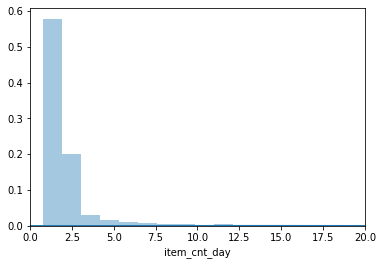

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df['item_cnt_day'], bins = 2000)
plt.xlim(0, 20)

This is the response variable we are trying to predict. Here we can see it is noticeably right-skewed, and in fact primarily comprises of 1 and 2 values.

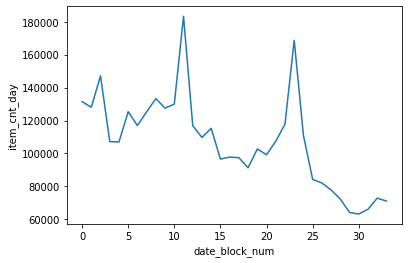

In [47]:
sales_by_date = df.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'})
sales_by_date = sales_by_date.reset_index()
sns.lineplot(sales_by_date['date_block_num'], sales_by_date['item_cnt_day'])

There's clearly two spikes in months 12 and 24, which are both in December. This suggests that holiday shopping drives up sales during that time. Overall, however, there is a downward trend in sale values.

(0, 50000)

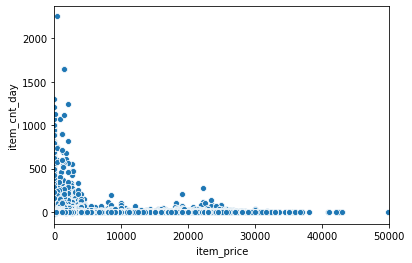

In [48]:
sns.scatterplot(df['item_price'], df['item_cnt_day'])
plt.xlim(0, 50000)

Higher priced items appear to have less sales. However, let's consider revenue as well.

(0, 50000)

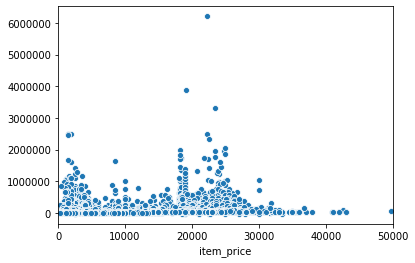

In [49]:
rev = df['item_price'] * df['item_cnt_day']
sns.scatterplot(df['item_price'], rev)
plt.xlim(0, 50000)

Comparing this to the previous plot, we can see that the lower priced items aren't necessarily better from a revenue standpoint.

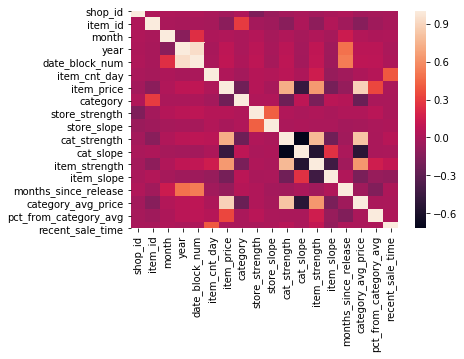

In [50]:
sns.heatmap(df.corr())

Here we see that many of our predictors are uncorrelated.

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
X = df.drop(columns = 'item_cnt_day')
y = df['item_cnt_day']


In [52]:
from sklearn.preprocessing import OneHotEncoder 
enc = OneHotEncoder()
"""
categories_encoded = pd.DataFrame(enc.fit_transform(df[['category']]).toarray())
categories_encoded.columns = enc.get_feature_names(['category'])
X = pd.concat([X, categories_encoded], axis=1)


categories_encoded = pd.DataFrame(enc.fit_transform(df[['month']]).toarray())
categories_encoded.columns = enc.get_feature_names(['month'])
X = pd.concat([X, categories_encoded], axis=1)
"""

X.drop(columns = ['shop_id', 'category', 'item_id', 'month', 'year'], inplace = True)

"""
categories_encoded = pd.DataFrame(enc.fit_transform(test_df_final[['category']]).toarray())
categories_encoded.columns = enc.get_feature_names(['category'])
test_df_final = pd.concat([test_df_final, categories_encoded], axis=1)


categories_encoded = pd.DataFrame(enc.fit_transform(test_df_final[['month']]).toarray())
categories_encoded.columns = enc.get_feature_names(['month'])
test_df_final = pd.concat([test_df_final, categories_encoded], axis=1)
"""

test_df_final.drop(columns = ['shop_id', 'category', 'item_id', 'month', 'year'], inplace = True)



In [53]:
X['cat_slope_by_time'] = X['cat_slope']*X['date_block_num']
X['store_slope_by_time'] = X['store_slope']*X['date_block_num']
X['item_slope_by_time'] = X['item_slope']*X['date_block_num']

In [54]:
test_df_final['cat_slope_by_time'] = test_df_final['cat_slope']*X['date_block_num']
test_df_final['store_slope_by_time'] = test_df_final['store_slope']*test_df_final['date_block_num']
test_df_final['item_slope_by_time'] = test_df_final['item_slope']*test_df_final['date_block_num']

In [55]:
test_df_final

,ID,date_block_num,item_price,store_strength,store_slope,cat_strength,cat_slope,item_strength,item_slope,months_since_release,category_avg_price,pct_from_category_avg,recent_sale_time,cat_slope_by_time,store_slope_by_time,item_slope_by_time
0,63787,34,129.0,2451.191504,27.185542,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-0.000000,924.308426,-5801.256384
1,99487,34,129.0,1775.728922,26.148025,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-0.000000,889.032864,-5801.256384
2,109687,34,129.0,2152.986144,11.420898,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-0.000000,388.310539,-5801.256384
3,22987,34,129.0,2837.279926,29.533829,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-0.000000,1004.150169,-5801.256384
4,206587,34,129.0,1855.028531,30.031846,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-0.000000,1021.082759,-5801.256384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,46377,34,299.0,2373.974404,29.523809,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874,1003.809495,-704.032200
214196,143277,34,299.0,1814.180035,35.862208,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874,1219.315071,-704.032200
214197,31077,34,299.0,1300.976338,20.793357,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874,706.974144,-704.032200
214198,138177,34,299.0,1886.414371,24.431474,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874,830.670129,-704.032200


In [56]:
"""
test_no_ID = test_df_final.drop(columns = 'ID')
temp = X.drop(columns = test_no_ID.columns)
for col in temp.columns:
    temp[col].values[:] = 0
len = test_df_final.shape[0]
test_df_final = pd.concat([test_df_final, temp[0:len-1]], axis=1)
"""
ID = test_df_final['ID']
test_df_final.drop(columns = 'ID', inplace = True)


In [57]:
"""
from sklearn.preprocessing import PolynomialFeatures
trans = PolynomialFeatures(degree=2)
X_arr = trans.fit_transform(X)
X = pd.DataFrame(X_arr)
test_df_final_arr = trans.fit_transform(test_df_final)
test_df_final = pd.DataFrame(test_df_final_arr)
"""

'\nfrom sklearn.preprocessing import PolynomialFeatures\ntrans = PolynomialFeatures(degree=2)\nX_arr = trans.fit_transform(X)\nX = pd.DataFrame(X_arr)\ntest_df_final_arr = trans.fit_transform(test_df_final)\ntest_df_final = pd.DataFrame(test_df_final_arr)\n'

In [58]:
# scale
from numpy import inf

test_df_final = test_df_final.replace(np.NaN, 0)
test_df_final = test_df_final.replace(np.inf, 0)
test_df_final[test_df_final['item_slope'] == -inf] = 0
X = X.replace(np.NaN, 0)
X = X.replace(np.inf, 0)
X[X['item_slope'] == -inf] = 0
#X['year'] = X['year'] - 2013
X

,date_block_num,item_price,store_strength,store_slope,cat_strength,cat_slope,item_strength,item_slope,months_since_release,category_avg_price,pct_from_category_avg,recent_sale_time,cat_slope_by_time,store_slope_by_time,item_slope_by_time
29662,0,399.0,2093.007105,46.013036,1648.207879,5.059647,616.763385,-2.616171,0,1077.399339,-0.629664,0.0,0.000000,0.000000,-0.000000
38751,0,76.0,986.542819,-15.535843,505.702206,-0.414580,201.180657,-0.148131,0,223.436335,-0.659858,0.0,-0.000000,-0.000000,-0.000000
39490,0,149.0,1265.788123,25.679212,505.702206,-0.414580,201.180657,-0.148131,0,223.436335,-0.333143,0.0,-0.000000,0.000000,-0.000000
45683,0,149.0,2465.046793,50.670181,505.702206,-0.414580,201.180657,-0.148131,0,223.436335,-0.333143,0.0,-0.000000,0.000000,-0.000000
46843,0,149.0,1771.384898,16.681663,505.702206,-0.414580,201.180657,-0.148131,0,223.436335,-0.333143,0.0,-0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578885,33,449.0,2373.974404,29.523809,402.912447,1.981293,1048.549573,-26.849412,33,281.804765,0.593302,1.0,65.382665,974.285686,-886.030603
1578393,33,449.0,1876.699674,13.091517,402.912447,1.981293,1048.549573,-26.849412,33,281.804765,0.593302,2.0,65.382665,432.020056,-886.030603
1583996,33,199.0,3893.976352,269.626824,2849.241281,132.006119,314.800000,-4.784848,28,377.991280,-0.473533,1.0,4356.201926,8897.685189,-157.900000
1580187,33,299.0,1701.810996,47.735128,402.912447,1.981293,465.518798,-17.039408,14,281.804765,0.061018,2.0,65.382665,1575.259230,-562.300454


In [59]:
test_df_final.drop(columns = 'date_block_num', inplace = True)
X.drop(columns = 'date_block_num', inplace = True)

In [60]:
X = (X - X.mean())/X.std()
test_df_final = (test_df_final - X.mean())/X.std()

In [61]:
"""
scaler = MinMaxScaler()
scaler.fit(X)
X_arr = scaler.transform(X)
X = pd.DataFrame(X_arr)
test_df_final_arr = scaler.transform(test_df_final)
test_df_final = pd.DataFrame(test_df_final_arr)
"""

'\nscaler = MinMaxScaler()\nscaler.fit(X)\nX_arr = scaler.transform(X)\nX = pd.DataFrame(X_arr)\ntest_df_final_arr = scaler.transform(test_df_final)\ntest_df_final = pd.DataFrame(test_df_final_arr)\n'

In [62]:
"""
lasso = linear_model.Lasso(alpha = 1.0)
lasso.fit(X,y)
pred = lasso.predict(test_df_final)
lasso.score(X,y)

reg = LinearRegression().fit(X, y)
reg.score(X, y)
"""

'\nlasso = linear_model.Lasso(alpha = 1.0)\nlasso.fit(X,y)\npred = lasso.predict(test_df_final)\nlasso.score(X,y)\n\nreg = LinearRegression().fit(X, y)\nreg.score(X, y)\n'

In [63]:
from sklearn import datasets, ensemble

params = {'n_estimators': 100,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 2.0,
          'loss': 'ls'}
# best so far: 100, 2, 5, 2

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X, y)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, reg.predict(X))
mse

74.82040862261323

In [64]:
test_df_final

,item_price,store_strength,store_slope,cat_strength,cat_slope,item_strength,item_slope,months_since_release,category_avg_price,pct_from_category_avg,recent_sale_time,cat_slope_by_time,store_slope_by_time,item_slope_by_time
0,129.0,2451.191504,27.185542,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-4.679348e-15,924.308426,-5801.256384
1,129.0,1775.728922,26.148025,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-4.679348e-15,889.032864,-5801.256384
2,129.0,2152.986144,11.420898,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-4.679348e-15,388.310539,-5801.256384
3,129.0,2837.279926,29.533829,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-4.679348e-15,1004.150169,-5801.256384
4,129.0,1855.028531,30.031846,505.702206,-0.414580,1497.929547,-170.625188,33.0,223.436335,-0.422654,1.0,-4.679348e-15,1021.082759,-5801.256384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,299.0,2373.974404,29.523809,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874e+00,1003.809495,-704.032200
214196,299.0,1814.180035,35.862208,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874e+00,1219.315071,-704.032200
214197,299.0,1300.976339,20.793357,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874e+00,706.974144,-704.032200
214198,299.0,1886.414371,24.431474,894.657029,-0.720625,877.444841,-20.706829,26.0,434.149023,-0.311296,1.0,-2.161874e+00,830.670129,-704.032200


Finaly, here we make our prediction using our trained gradient boost regression.

In [65]:
pred = reg.predict(test_df_final.dropna())

In [66]:
pred = pd.DataFrame(pred)
pred.insert(0, 'ID', range(0, pred.shape[0]))
pred.columns = ['ID', 'item_cnt_month']

In [67]:
pred.to_csv('output_test.csv', index=False)